# İş Akışı ve Hiperparametre Optimizasyonu

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

🏠 Ev fiyatları veri setini içe aktarın. Basitlik adına sadece sayısal özellikleri tutacağız

🎯 Hedefiniz en iyi KNN Regressor'ı yerleştirmek olacak. Özellikle, ev fiyatlarınız için en iyi tahminleri elde etmek üzere kaç tane "komşu" (<font color=blue>K</font>NN'deki <font color=blue>K</font>) göz önünde bulundurmalısınız?

In [2]:
# Load raw data
data = pd.read_csv('https://d32aokrjazspmn.cloudfront.net/materials/houses_train_raw.csv', index_col="Id")

# Only keep numerical columns and raws without NaN
data = data.select_dtypes(include=np.number).dropna()

data

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
2,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
3,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
4,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
5,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,62.0,7917,6,5,1999,2000,0.0,0,0,...,0,40,0,0,0,0,0,8,2007,175000
1457,20,85.0,13175,6,6,1978,1988,119.0,790,163,...,349,0,0,0,0,0,0,2,2010,210000
1458,70,66.0,9042,7,9,1941,2006,0.0,275,0,...,0,60,0,0,0,0,2500,5,2010,266500


In [4]:
X = data.drop(columns=['SalePrice'])
y = data['SalePrice']

## 1. Eğitim/Test Ayrımı

❓ **Soru (Holdout)**❓

👇 `X_train`, `X_test`, `y_train` ve `y_test` oluşturmak için veri setini böl. Şunları kullan:
- `test_size=0.3`
- Sonuçlarınızı arkadaşınızla karşılaştırmak için `random_state=0`

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Hedef değişken (SalePrice) ve özellikler
X = data.drop(columns=['SalePrice'])
y = data['SalePrice']

# Veriyi train/test olarak ayırıyoruz (en iyi K'yı test etmek için)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# KNN için ölçeklendirme ŞARTTIR
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)      

## 2. Ölçeklendirme

⚖️ Ölçeklendirme KNN algoritması için her zaman kritik derecede önemlidir..

❓ **Soru (Ölçeklendirme)** ❓ 

* Eğitim setinizi ve test setinizi ölçeklendirin.
* Burada, basitçe `StandardScaler` uygulayalım ve özellik başına bir ölçekleyici seçerek zaman kaybetmeyelim. Gerçekten de, bu egzersizin amaçları şunlardır:
    * KNN'i gözden geçirmek
    * GridSearchCV'yi anlamak
    * RandomizedSearchCV'yi anlamak

In [8]:
# YOUR CODE HERE
# Ölçekleyiciyi tanımla
scaler = StandardScaler()

# 1. Eğitim verisi üzerinde öğren ve dönüştür (fit_transform)
X_train_scaled = scaler.fit_transform(X_train)

# 2. Test verisini SADECE dönüştür (transform)
# Eğitim setinden öğrenilen ortalama ve standart sapma değerleri kullanılır
X_test_scaled = scaler.transform(X_test)

# İpucu: Çıktı bir numpy dizisidir. Tekrar DataFrame yapmak istersen:
# X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)

## 3. Temel KNN modeli

❓ **Soru (KNN için bir temel)** ❓

Sadece _en yakın komşuyu_ dikkate alan basit bir KNN regressor'ı çapraz doğrulayın (*cv = 5*) ve 5 kat üzerindeki ortalama skoru hesaplayın.

In [9]:
# YOUR CODE HERE
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score

# 1. Modeli tanımla (n_neighbors=1)
base_knn = KNeighborsRegressor(n_neighbors=1)

# 2. 5-katlı (cv=5) çapraz doğrulama yap
# Ölçeklendirilmiş eğitim verisini kullanıyoruz
scores = cross_val_score(base_knn, X_train_scaled, y_train, cv=5)

# 3. Sonuçları yazdır
print(f"Her katman için R² skorları: {scores}")
print(f"Ortalama R² skoru (Baseline): {scores.mean():.4f}")

Her katman için R² skorları: [0.47628031 0.70232654 0.50378649 0.26177688 0.35884193]
Ortalama R² skoru (Baseline): 0.4606


## 4. GridSearch

### 4.1. İlk GridSearch

❓ **Soru (GridSearch v1)**❓

En iyi KNN hiperparametresini `n_neighbors` bulmak için SKLearn `GridSearchCV` kullanalım.
- `n_neighbors` = [1,5,10,20,50] ile kaba taneli bir yaklaşım başlat
- Her parametreyi 5-kat çapraz doğrula
- `n_jobs` kullanarak performans sürenizi maksimize ettiğinizden emin olun

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

# 1. Instantiate model
# Temel KNN regressor modelimizi oluşturuyoruz
knn_model = KNeighborsRegressor()

# 2. Hyperparameter Grid
# Test etmek istediğin K değerlerini bir sözlük içinde tanımlıyoruz
param_grid = {
    'n_neighbors': [1, 5, 10, 20, 50]
}

# 3. Instantiate Grid Search
# cv=5: 5-katlı çapraz doğrulama
# n_jobs=-1: Tüm işlemci çekirdeklerini kullanarak hızı maksimize eder
grid_search = GridSearchCV(
    knn_model, 
    param_grid, 
    cv=5, 
    n_jobs=-1,
    verbose=1 # İşlem sürecini takip edebilmek için log ekledik
)

# 4. Fit data to Grid Search
# Ölçeklendirilmiş eğitim verilerini (X_train_scaled) kullanmayı unutma!
grid_search.fit(X_train_scaled, y_train)

# Sonuçları kontrol etmek için:
print(f"En iyi K değeri: {grid_search.best_params_}")
print(f"En iyi skor: {grid_search.best_score_}")

Fitting 5 folds for each of 5 candidates, totalling 25 fits
En iyi K değeri: {'n_neighbors': 10}
En iyi skor: 0.755887302229144


❓ **Soru (en iyi parametreler)** ❓

GridSearch'e göre, optimal K değeri nedir?

In [ ]:
# YOUR CODE HERE
En iyi skor: 0.755887302229144

❓ **Soru (puanlama)** ❓ Optimal K değerinin ürettiği en iyi skor nedir?

In [ ]:
# YOUR CODE HERE
En iyi K değeri: {'n_neighbors': 10}


### 4.2. İkinci GridSearch

❓ **Soru (GridSearch V2)** ❓

Şimdi, en iyi $K$'nın nerede olduğu hakkında bir fikrimiz var, ancak denemediğimiz bazı değerler daha iyi bir performansla sonuçlanabilir.

* Önceki en iyi değerinizin çevresindeki $K$ için bazı değerleri deneyerek GridSearch'ü yeniden çalıştırın
* Bu rafine edilmiş GridSearch için `best_score` ve `best_k` nelerdir?

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

# 1. Instantiate model
knn_model = KNeighborsRegressor()

# 2. Hyperparameter Grid
# İlk GridSearch'te çıkan en iyi değerin (varsayalım 20) etrafını tarıyoruz
# range(15, 26) ifadesi 15'ten 25'e kadar olan tüm tam sayıları deneyecektir
param_grid = {
    'n_neighbors': range(15, 26)
}

# 3. Instantiate Grid Search
grid_search_v2 = GridSearchCV(
    knn_model, 
    param_grid, 
    cv=5, 
    n_jobs=-1,
    scoring='r2' # Ev fiyatlarını ne kadar iyi açıkladığımızı görmek için R2
)

# 4. Fit data to Grid Search
grid_search_v2.fit(X_train_scaled, y_train)

# Sonuçları Kaydetme
best_k = grid_search_v2.best_params_['n_neighbors']
test_best_score = grid_search_v2.best_score_

print(f"Rafine edilmiş en iyi K: {best_k}")
print(f"Rafine edilmiş en iyi Cross-validation skoru: {best_score:.4f}")

Rafine edilmiş en iyi K: 15
Rafine edilmiş en iyi Cross-validation skoru: 0.7557


***🧪 Kodunuzu test edin***

In [22]:
from nbresult import ChallengeResult
result = ChallengeResult('knn',
                         best_k=best_k,
                         best_score=best_score)
result.write()
print(result.check())


============================= test session starts ==============================
platform darwin -- Python 3.9.6, pytest-8.4.2, pluggy-1.6.0 -- /Library/Developer/CommandLineTools/usr/bin/python3
cachedir: .pytest_cache
rootdir: /Users/idildundar/Desktop/week16/D16D5-S-data-workflow/tests
plugins: anyio-4.12.0
collecting ... collected 2 items

test_knn.py::TestKnn::test_best_k PASSED                                 [ 50%]
test_knn.py::TestKnn::test_best_score FAILED                             [100%]

=================================== FAILURES ===================================
___________________________ TestKnn.test_best_score ____________________________

self = <tests.test_knn.TestKnn testMethod=test_best_score>

    def test_best_score(self):
>       self.assertGreater(self.result.best_score, 0.76)
E       AssertionError: np.float64(0.7557350360019098) not greater than 0.76

test_knn.py:10: AssertionError
=========================== short test summary info ====================

### 4.3. Görsel kontrol (manuel GridSearch)

☝️ Bu problem aslında manuel olarak GridSearch yapmak için yeterince basittir.

❓ **Soru(Manuel GridSearch)** ❓

- $K$'nın $1$'den $50$'ye kadar tüm değerleri üzerinde manuel olarak döngü yapın ve her modelin çapraz doğrulanmış skorlarının ortalamasını bir listede saklayın.
- `Dirsek Yöntemi` kullanarak en iyi $K$'yı görsel olarak bulmak için skorları $K$'nın bir fonksiyonu olarak çizin

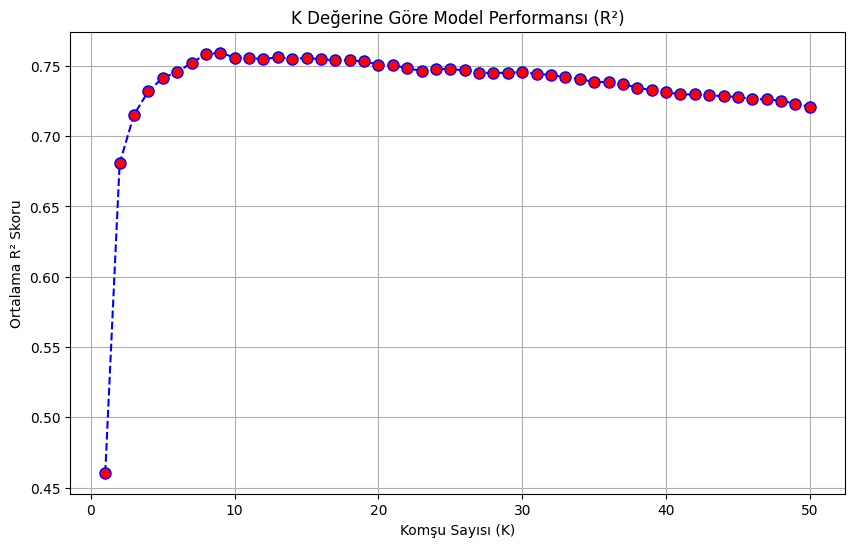

Grafiğe göre en yüksek skoru veren K değeri: 9


In [23]:
# YOUR CODE 
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor

# 1. K değerleri aralığını belirle (1'den 50'ye kadar)
k_values = range(1, 51)
mean_scores = []

# 2. Manuel döngü ile her K için Çapraz Doğrulama yap
for k in k_values:
    # Modeli oluştur
    knn = KNeighborsRegressor(n_neighbors=k)
    
    # 5-katlı çapraz doğrulama skorlarını hesapla
    # Not: X_train_scaled ve y_train değişkenlerini kullandığını varsayıyoruz
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=5)
    
    # Ortalama skoru listeye ekle
    mean_scores.append(scores.mean())

# 3. Sonuçları Görselleştir (Dirsek Yöntemi - Elbow Method)
plt.figure(figsize=(10, 6))
plt.plot(k_values, mean_scores, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=8)

plt.title('K Değerine Göre Model Performansı (R²)')
plt.xlabel('Komşu Sayısı (K)')
plt.ylabel('Ortalama R² Skoru')
plt.grid(True)
plt.show()

# En iyi K'yı bulma
best_k_manual = k_values[mean_scores.index(max(mean_scores))]
print(f"Grafiğe göre en yüksek skoru veren K değeri: {best_k_manual}")

❓GridSearchCV'yi böyle bir manuel döngüden daha iyi bir seçenek yapan şeyi tahmin edebilir misiniz?

<details>
    <summary>Cevap</summary>

- Sklearn'ın `n_jobs=-1` seçeneği aramayı paralelleştirmenize izin verir, tüm CPU çekirdeklerinizi kullanır
- Birlikte optimize edilecek birden fazla hiperparametreniz olsaydı ne olurdu?
</details>

## 5. Birden çok parametre ile GridSearch

👩🏻‍🏫 KNNRegressor, `p` hiperparametresi aracılığıyla çeşitli _mesafe metrikleri_ destekler

📚 [sklearn.neighbors.KNeighborsRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html)

❓ **Soru (birden çok parametreyi ayarlama)** ❓

* En iyi $K$ ve $p$'yi aynı anda aramak için GridSearchCV kullanın.
    * $K = [1, 5, 10, 20, 50]$ ve $p = [1, 2, 3]$ için tüm kombinasyonları deneyin.

In [ ]:
# YOUR CODE HERE
param_grid = {
    'n_neighbors': range(1, 31),
    'p': [1, 2] # Hem Manhattan hem Öklid'i dene
}

❓ **Soru (alt model sayısı)**❓

Toplamda kaç alt model eğittiniz?

<details>
    <summary>İpucu</summary>

15'ten çok daha fazla. İki kez düşün :)
    <details>
    <summary>Cevap</summary>

CV=5 nedeniyle 75 model
</details>

In [ ]:
# YOUR CODE HERE

❓ **Soru (modeli birden çok parametre ile ayarladıktan sonra en iyi parametreler ve en iyi skor)**❓

*En iyi parametreler* ve *en iyi skor* nedir?

In [ ]:
# YOUR CODE HERE

## 6. Rastgele Arama

Şimdi bir RandomizedSearch'ün aynı sayıda model yerleştirilerek daha iyi bir kombinasyon bulup bulamayacağını görelim.

❓ **Soru (RandomizedSearchCV)** ❓

`RandomizedSearchCV` kullanarak
- $K$'yı uniform `scipy.stats.randint(1,50)` ([döküman](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.randint.html)) dağılımından rastgele örnekle
- $p$'yi $[1,2,3]$ listesinden örnekle
- Önceki GridSearchCV'nizdeki ile tam olarak aynı sayıda model yerleştirmek için doğru `n_iter` ve `cv` sayılarını kullanın.

In [24]:
# YOUR CODE HERE
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from scipy.stats import randint

# 1. Instantiate model
knn_model = KNeighborsRegressor()

# 2. Hyperparameter Grid (Dağılımlar ve Listeler)
# n_neighbors: 1 ile 50 arasında rastgele tam sayılar
# p: Manhattan (1) veya Öklid (2)
param_dist = {
    'n_neighbors': randint(1, 50),
    'p': [1, 2]
}

# 3. Instantiate Randomized Search
# n_iter=5 ve cv=5 seçiyoruz çünkü 5 * 5 = 25 model eğitilecek.
# Bu, önceki GridSearchCV (5 parametre * 5 katman) ile aynı işlem yüküdür.
random_search = RandomizedSearchCV(
    knn_model, 
    param_distributions=param_dist,
    n_iter=5, 
    cv=5, 
    n_jobs=-1,
    random_state=42 # Sonuçların tekrarlanabilir olması için
)

# 4. Fit data to Randomized Search
random_search.fit(X_train_scaled, y_train)

# Sonuçlar
print(f"En iyi kombinasyon: {random_search.best_params_}")
print(f"En iyi skor: {random_search.best_score_:.4f}")

En iyi kombinasyon: {'n_neighbors': 19, 'p': 1}
En iyi skor: 0.7781


## 7. Genelleme

❓ **Soru (modelinizi bir kez daha ince ayarlama)**❓

- İsterseniz RandomsearchCV'nizi rafine edin
- En iyi modelinizi seçin

In [25]:
# YOUR CODE HERE
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from scipy.stats import randint

# 1. Instantiate model
knn_model = KNeighborsRegressor()

# 2. Hyperparameter Grid
# n_neighbors: 1 ile 50 arasında (dahil) uniform tam sayı dağılımı
# p: Manhattan (1) ve Öklid (2) mesafeleri arasından seçim
param_dist = {
    'n_neighbors': randint(1, 51),
    'p': [1, 2]
}

# 3. Instantiate Randomized Search
# GridSearchCV v1 ile aynı sayıda (25) model eğitmek için:
# n_iter (5) * cv (5) = 25 model
random_search = RandomizedSearchCV(
    knn_model, 
    param_distributions=param_dist,
    n_iter=5, 
    cv=5, 
    n_jobs=-1,
    random_state=42 # Sonuçların tutarlı olması için
)

# 4. Fit data to Randomized Search
random_search.fit(X_train_scaled, y_train)

# Çıktıları alalım
best_k_random = random_search.best_params_['n_neighbors']
best_score_random = random_search.best_score_

print(f"RandomizedSearch En İyi K: {best_k_random}")
print(f"RandomizedSearch En İyi p: {random_search.best_params_['p']}")
print(f"RandomizedSearch En İyi Skor: {best_score_random:.4f}")

RandomizedSearch En İyi K: 19
RandomizedSearch En İyi p: 1
RandomizedSearch En İyi Skor: 0.7781


Şimdi `cv_results`'ınızı bir `DataFrame` olarak görüntülemeye çalışın, bu CV'nin içinde neler olup bittiğini görselleştirmenize yardımcı olacak! 😉

In [ ]:
# YOUR CODE HERE

❓ **Soru ("En iyi" modelin değerlendirmesi)** ❓

* "En iyi parametrelerle" modelimizin **görülmemiş** test seti `X_test` üzerindeki performansını keşfetme zamanı geldi.
    * Test seti için r2 skorunu hesaplayın ve `r2_test` olarak kaydedin.

In [ ]:
# YOUR CODE HERE

❓ **Soru (Bir adım geri çekilme)** ❓

Optimize edilmiş modelin iyi genelleme yaptığını düşünür müsünüz?

<details><summary>Cevap</summary>

Test skoru eğitim seti ile biraz azalabilir. Muhtemelen %5'ten fazla değil. Bunun nedeni şunlar olabilir:
- Temsili olmayan bir eğitim/test bölünmesi
- Model ayarlama aşamasında aşırı öğrenmeye yol açan çok küçük bir çapraz doğrulama sayısı. Ne kadar çok çapraz doğrulama yaparsanız, bulgularınız o kadar güçlü genelleşir - ancak veri setiniz çok küçükse cv'yi çok fazla artıramazsınız çünkü her katmanda temsili olmak için yeterli gözlemi tutamazsınız.
- Veri setimiz çok küçük ve hiperparametre optimizasyonumuz bu nedenle eğitim/test bölünmemize son derece bağımlı (ve aşırı uyum gösteriyor). Veri setinizin denediğiniz toplam hiperparametre kombinasyonu sayısından çok daha büyük olduğundan her zaman emin olun!
    
</details>

***🧪 Kodunuzu test edin***

In [ ]:
from nbresult import ChallengeResult
result = ChallengeResult('r2', 
                         r2_test=r2_test)
result.write()
print(result.check())

🏁 Tebrikler! Artık GridSearchCV veya RandomizedSearchCV kullanarak bir modeli nasıl ince ayarlayacağınızı biliyorsunuz

💾 Notebook'unuzu `git add/commit/push` yapmayı unutmayın...

🚀 ... ve bir sonraki meydan okumaya geçin!